# LEAP Plotting in Jupyter

Easy access to visualization makes for a smooth algorithm development cycle. LEAP offers components to assist with plotting algorithms and problems with `matplotlib` and Jupyter.

The key to live animation in Jupyter is to use the `%matplotlib notebook` magic:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

If you use `%matplotlib inline` instead, you'll end up with a static image.

## Live BSF Curves

We usually visualize things in LEAP the same way we measure anything: with a **probe operator**.

When `PopulationPlotProbe` is inserted into an operator pipeline, it captures the whole population at each generation and plots a statistic from it.  By default, it measures the **best-of-generation fitness**.

Next we'll create the probe operator.  It will automatically set up a figure and prepare to plot to it.  The probe will automatically scale the axes to ensure that the entire curve stays within view, but here we'llmanually set the initial `ylim` bounds to add more space:

<IPython.core.display.Javascript object>


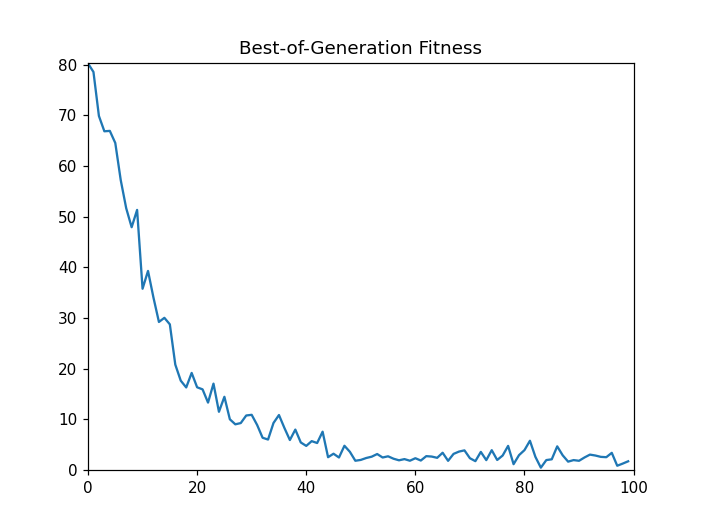

In [2]:
from leap_ec.probe import FitnessPlotProbe

# The probe needs access to a context object so that it can read the global generation counter
plot_probe = FitnessPlotProbe(ylim=(0, 70))

Not much is happening yet.  We've created the probe and attached it to a figure—but it **still needs an algorithm!**

Let's run a simple generational, real-valued EA to solve the `Spheroid` function.  We want the population to pass through the probe at each iteration, so that it can collect data for the y-coordinate.  We achieve this by inserting it at the end of the operator pipeline:
 
 ```Python
 pipeline=[
           ...,
           ops.pool(size=pop_size),
           plot_probe
       ]
 ```

We put the probe right after `ops.pool` because the probe needs to receive the **population** all at once, instead of of one individual at a time (`ops.pool` takes a stream of generated individuals and makes a population from it).

In [3]:
from leap_ec.algorithm import generational_ea
from leap_ec.individual import Individual
from leap_ec.decoder import IdentityDecoder
from leap_ec.representation import Representation
import leap_ec.ops as ops


from leap_ec.real_rep.problems import SpheroidProblem, SchwefelProblem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

l=10
pop_size=10
final_pop = generational_ea(max_generations=100, pop_size=pop_size,
                     problem=SpheroidProblem(maximize=False),
                     
                     representation=Representation(
                         individual_cls=Individual,
                         decoder=IdentityDecoder(),
                         initialize=create_real_vector(bounds=[[-5.12, 5.12]] * l)
                     ),

                     pipeline=[
                         ops.tournament_selection,
                         ops.clone,
                         mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                         ops.evaluate,
                         ops.pool(size=pop_size),
                         plot_probe  # Insert the probe into the pipeline like so
                     ])

Scroll up to the previous cell while the algorithm is running—the live results get placed there, thanks to the callbacks on `plot_probe`!

## Viewing Fitness Functions

When dealing with basic benchmark functions, we very often want to take a look at the problem we're solving (at the very least to make sure we're solving the right one!).

To save you typing with `matplotlib`, LEAP offers convenience methods for plotting real-valued fitness surfaces.

Here's how we'd view a surface plot for the `SpheroidProblem`:

<IPython.core.display.Javascript object>


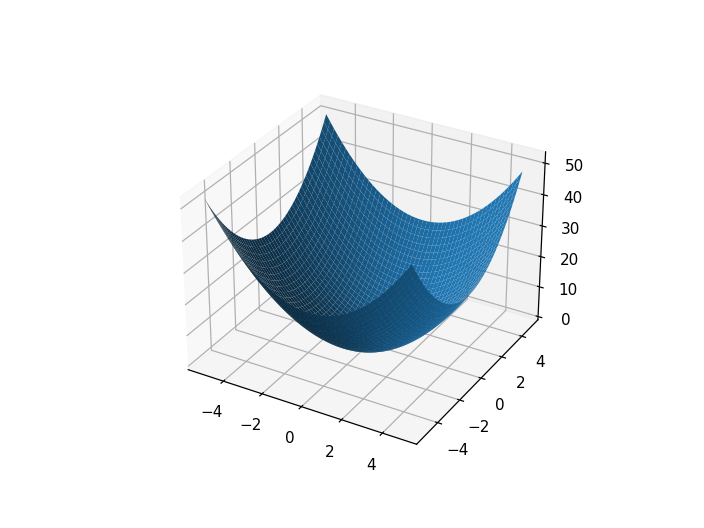

In [4]:
from leap_ec.real_rep.problems import plot_2d_problem

plot_2d_problem(SpheroidProblem(), xlim=(-5.12, 5.12), ylim=(-5.12, 5.12));

You can also plot a function's fitness contours.

This time we'll explicitly set up a `matplotlib` figure and tell `plot_2d_problem` to plot to its axes (with the `ax=plt.gca()` parameter).  This allows us to configure subplots and arrange them side-by-side (using standard `matplotlib` foo:

<IPython.core.display.Javascript object>


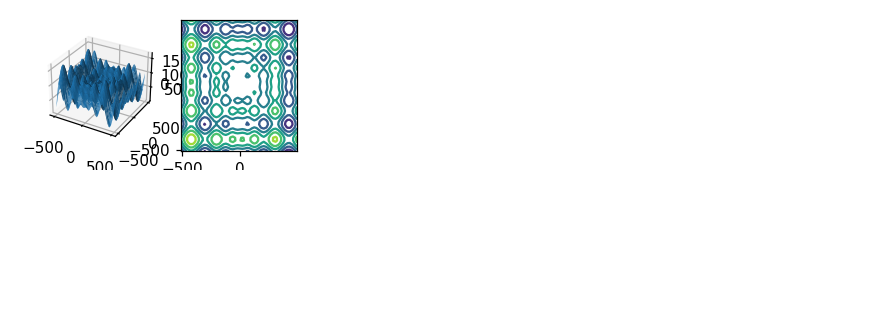

In [5]:
problem = SchwefelProblem()
bounds = problem.bounds

fig = plt.figure(figsize=(8, 3))

plt.subplot(121, projection='3d')
plot_2d_problem(problem, xlim=bounds, ylim=bounds, ax=plt.gca())

plt.subplot(122)
plot_2d_problem(problem, kind='contour', xlim=bounds, ylim=bounds, ax=plt.gca());

## Viewing Population Trajectories



<IPython.core.display.Javascript object>


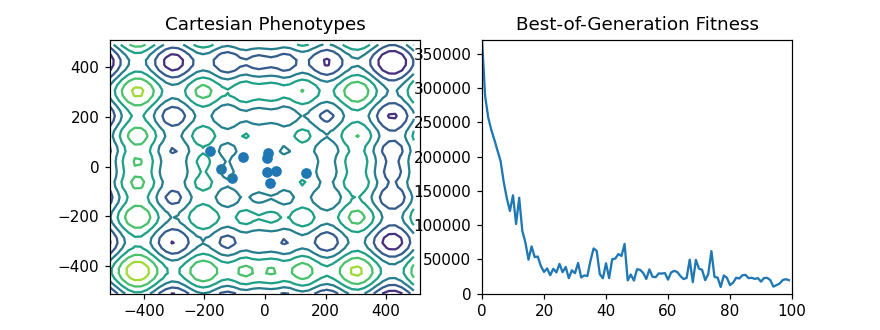

In [6]:
from leap_ec.probe import CartesianPhenotypePlotProbe

plt.figure(figsize=(8, 3))  # Setup a figure to plot to

plt.subplot(121)
trajectory_probe = CartesianPhenotypePlotProbe(contours=problem, ax=plt.gca(), xlim=bounds, ylim=bounds)

plt.subplot(122)
fitness_probe = FitnessPlotProbe(ax=plt.gca())

In [7]:
from leap_ec.algorithm import generational_ea

l=10
pop_size=10
final_pop = generational_ea(max_generations=100, pop_size=pop_size,
                     problem=SpheroidProblem(maximize=False),
                     
                     representation=Representation(
                         decoder=IdentityDecoder(),
                         initialize=create_real_vector(bounds=[problem.bounds] * l)
                     ),

                     pipeline=[
                         ops.tournament_selection,
                         ops.clone,
                         mutate_gaussian(std=50,
                                         expected_num_mutations='isotropic',
                                         hard_bounds=problem.bounds),
                         ops.evaluate,
                         ops.pool(size=pop_size),
                         trajectory_probe,  # Insert the probes into the pipeline like so
                         fitness_probe
                     ])